As I mentioned [before](/python/hoops/2015/08/12/ivy-heatmaps.html), I'm a big Cornell basketball fan. One particular point of contention among Cornell basketball fans is whether the current coach Bill Courtney makes strategically sound decisions during games; the consensus among fans (or rather, the subset of fans that takes to the internet to complain) is that he's a bad in-game coach, at least compared to the previous coach Steve Donahue. This certainly isn't unique to Cornell -- lots of fanbases are unhappy with their coach's in-game coaching abilities (see Crean, Tom) -- but Cornell presents a nice case for analysis because we have a (comparatively) decent amount of data from both B.C and A.D eras (before Courtney, and after Donahue, natch). 

There are lots of factors that go into a team's success or failure besides in-game coaching, but in this post I'm only asking "Is Bill Courtney a worse in-game coach than Steve Donahue?" Inspired by an example in [Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/) I'm going to try to address this question using historical box score data and some Bayesian tools.

The plan of attack:
- Generate a regression that predicts the number of wins / winning percentage a team should have, based on its season-averaged box score statistics. 
- Compare Cornell's actual number of wins / winning percentage to the predicted value, for each season for which we have data.
- Do some Bayesian analysis to estimate whether there was a change in performance relative to box-score based expectations that coincided with the coaching change. 

The premise is that, given a fixed set of stats, differences in game outcomes are determined by in-game coaching decisions (i.e. when to call a time-out, what kind of play to draw up in important situations, etc). This certainly isn't completely true, but hopefully it will be good enough to say something interesting.

I'll note at the outset that this isn't a particularly rigorous analysis. First, we're limited by the fact that our data only go back to the 2001-2002 season. Any conclusions we can draw from such a small sample size are necessarily going to be imprecise. Second, the 'data' that we're using for our Bayesian analysis is a function of a predicted number of wins. This exposes us to errors from bad predictions. Finally, it's possible that the effect of a particular coach's in-game coaching abilities is actually uncorrelated with the difference between actual and predicted wins. Caveats aside, let's see what we can do.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn import linear_model, cross_validation, metrics, ensemble
from scipy.stats import pearsonr

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
# a helper function to facilitate loading multiple csv files
def get_data(filename, icol=None, columns=None):
    df = pd.read_csv(filename, sep=',', encoding='latin-1', \
                     skipinitialspace=True, index_col=icol, usecols=columns)
    df['filename'] = filename
    return df

In [4]:
# load box score data
filenames = [str(yr)+'_box_scores.csv' for yr in range(2009,2016)]
frames  = [get_data('../hoops/data/'+f) for f in filenames]

# index the full dataframe by the filename where the raw data came from
boxes_full = pd.concat(frames, keys=filenames)

In [5]:
# load game score data
filenames = [str(yr)+'_game_scores.csv' for yr in range(2009,2016)]
frames  = [get_data('../hoops/data/'+f, 0) for f in filenames]

# index the full dataframe by the filename where the raw data came from
games_full = pd.concat(frames)

In [6]:
# get the names of every team that has a home game in the data
names_full = games_full.reset_index().groupby('home_name').count().game_ID

# filter out teams with less than 10 home games in the whole dataset
# these will be non-Division I teams
team_list = names_full[names_full>10].index

In [7]:
# add a column with the season, pulled from the filename
boxes_full['season'] = boxes_full.apply(lambda row: row.filename.split('/')[-1][:4], axis=1)
games_full['season'] = games_full.apply(lambda row: row.filename.split('/')[-1][:4], axis=1)

In [8]:
# create dataframe with away scores, indexed by (season, home_name, game_ID)
papg_home = games_full[['home_name','away_final','season']]
papg_away = games_full[['away_name','home_final','season']]

# reset the multiindex to match the game_sums index
papg_home = papg_home.reset_index().groupby(['season','home_name','game_ID']).first()['away_final']
papg_away = papg_away.reset_index().groupby(['season','away_name','game_ID']).first()['home_final']

papg_home.index.names = ['season','team_name','game_ID']
papg_away.index.names = ['season','team_name','game_ID']

papg_home.columns = ['PAPG']
papg_away.columns = ['PAPG']

# combine home and away papg
papg = pd.concat([papg_home, papg_away], axis=1).fillna(0)
papg['PAPG'] = papg['away_final'] + papg['home_final']

In [9]:
box_stats = ['3PA', 'AST', 'BLK', 'FGA', 'FTA', 'OREB', 'PF', 'PTS', 'REB', 'STL', 'TO']
full_stats = ['3PA', 'AST', 'BLK', 'FGA', 'FTA', 'OREB', 'PF', 'PTS', 'REB', 'STL', 'TO', 'PAPG','diff_DEF']

# group by game, sum up results
game_sums_part = boxes_full.groupby(['season','team_name','game_ID']).sum()[box_stats]

# incorporate PAPG stats
game_sums = pd.concat([game_sums_part, papg['PAPG']], axis=1).dropna()

# average over games to get season averages
team_avgs = game_sums.mean(level=[0,1])

In [10]:
# calculate total wins and total games for each team 
games_full['home_win'] = games_full.apply(lambda row: 1 if row.home_final > row.away_final else 0, axis=1)
games_full['away_win'] = games_full.apply(lambda row: 1 if row.home_final < row.away_final else 0, axis=1)

home_wins = games_full.groupby(['season','home_name']).sum()['home_win']
away_wins = games_full.groupby(['season','away_name']).sum()['away_win']

wins = pd.concat([away_wins,home_wins], axis=1).dropna()
wins['total_wins'] = wins['away_win'] + wins['home_win']
wins.index.names = ['season','team_name']

In [11]:
# combine win data with stat data into one dataframe
fitting_data = pd.concat([team_avgs, wins], axis=1).dropna()
fitting_data = fitting_data.loc[fitting_data.index.get_level_values('team_name').isin(team_list)]

In [12]:
# shouldn't be necessary next time
games_full = games_full.reset_index().set_index('game_ID')

In [13]:
# calculate offensive and defensive 'effectiveness'
# ie how much above or below their averages opposing teams perform against this team
def calc_eff(row, stat='OFF'):
    
    season = row.name[0]
    team_name = row.name[1]
    
    # get the game_ID for each game this team played this season
    game_IDs = game_sums.ix[season, team_name].index
    
    # pull the final scores for each game
    games = games_full[games_full.index.isin(game_IDs)][['season','away_name','away_final','home_name','home_final']]
    
    # break into home and away games, and reshape the index so it matches the index of fitting_data
    home_games = games.loc[games['home_name']==team_name].reset_index().set_index(['season','away_name'])
    away_games = games.loc[games['away_name']==team_name].reset_index().set_index(['season','home_name'])
    
    # drop results from non-DI games
    try:
        home_games.drop('Non D-I School', level=1, inplace=True)
        away_games.drop('Non D-I School', level=1, inplace=True)
        
        # hack to remove empty row from multindex, see https://github.com/pydata/pandas/issues/2770
        home_games = home_games.reset_index().groupby(['season','away_name']).first()
        away_games = away_games.reset_index().groupby(['season','home_name']).first()
    except KeyError:
        pass

    # add the season average PPG and PAPG for each opponent to the dataframe
    home_opp_stats = pd.concat([home_games, fitting_data.ix[home_games.index][['PTS','PAPG']]], axis=1)
    away_opp_stats = pd.concat([away_games, fitting_data.ix[away_games.index][['PTS','PAPG']]], axis=1)
    
    # rename columns to merge home and away dataframes
    home_opp_stats.columns = ['game_ID','opp_PTS','team_name','opp_PTSA','opp_PPG','opp_PAPG']
    home_opp_stats.index.names = ['season','opp_name']
    away_opp_stats.columns = ['game_ID','team_name', 'opp_PTSA','opp_PTS','opp_PPG','opp_PAPG']
    away_opp_stats.index.names = ['season','opp_name']
    
    opp_stats = pd.concat([home_opp_stats, away_opp_stats])
    

    # positive is good
    opp_stats['DEF_eff'] = opp_stats['opp_PPG'] - opp_stats['opp_PTS']
    opp_stats['OFF_eff'] = opp_stats['opp_PTSA'] - opp_stats['opp_PAPG']

    # return the mean over all opponents
    return opp_stats[stat+'_eff'].mean()

In [14]:
fitting_data['DEF_eff'] = fitting_data.apply(calc_eff, stat='DEF', axis=1)
fitting_data['OFF_eff'] = fitting_data.apply(calc_eff, stat='OFF', axis=1)

In [16]:
print(fitting_data.head())

                             3PA        AST       BLK        FGA        FTA  \
season team_name                                                              
2009   AR-Little Rock  14.354839  13.032258  3.483871  51.258065  23.000000   
       AR-Pine Bluff   13.903226  10.935484  2.709677  57.032258  20.935484   
       Air Force       17.612903  12.193548  2.258065  44.806452  18.806452   
       Akron           21.514286  12.314286  2.257143  54.628571  19.628571   
       Alabama         15.000000  11.156250  4.500000  59.843750  22.218750   

                            OREB         PF        PTS        REB       STL  \
season team_name                                                              
2009   AR-Little Rock   9.645161  19.612903  66.419355  31.516129  5.516129   
       AR-Pine Bluff   11.838710  22.677419  62.677419  33.580645  8.741935   
       Air Force        6.193548  17.483871  58.741935  25.838710  5.000000   
       Akron            9.600000  20.657143  66.828

There's a fair amount of data wrangling that goes into converting the raw box score data into a form we can use. I'll omit that here, but it's included in the [ipython notebook](/notebooks/Bloglink) for this post. Once it's all wrangled, our data looks like this:

In [347]:
# the list of stats used in our predictions
fit_stats = ['3PA', 'AST', 'BLK', 'FGA', 'FTA', 'OREB', 'PTS','REB', 'STL', 'TO','PAPG']

print(fitting_data[fit_stats + ['total_wins']].head())

                             3PA        AST       BLK        FGA        FTA  \
season team_name                                                              
2009   AR-Little Rock  14.354839  13.032258  3.483871  51.258065  23.000000   
       AR-Pine Bluff   13.903226  10.935484  2.709677  57.032258  20.935484   
       Air Force       17.612903  12.193548  2.258065  44.806452  18.806452   
       Akron           21.514286  12.314286  2.257143  54.628571  19.628571   
       Alabama         15.000000  11.156250  4.500000  59.843750  22.218750   

                            OREB        PTS        REB       STL         TO  \
season team_name                                                              
2009   AR-Little Rock   9.645161  66.419355  31.516129  5.516129  14.741935   
       AR-Pine Bluff   11.838710  62.677419  33.580645  8.741935  19.096774   
       Air Force        6.193548  58.741935  25.838710  5.000000  12.709677   
       Akron            9.600000  66.828571  29.342

Each stat in `fit_stats` will be a predictor in our model, while `total_wins` is the dependent variable.

Before we fit our predictive model we need to split the data into training and testing sets.

In [439]:
# split our data into subsets for testing and training
X_train, X_test, y_train, y_test = \
cross_validation.train_test_split(fitting_data[fit_stats], \
                                  fitting_data['total_wins'],\
                                  test_size=0.4, random_state=0)

#other_ivies = ['Harvard','Yale','Princeton','Penn','Dartmouth','Columbia','Brown']
#X_train = fitting_data.loc[fitting_data.index.isin(other_ivies, level='team_name')][full_stats]
#y_train = fitting_data.loc[fitting_data.index.isin(other_ivies, level='team_name')]['total_wins']

Time to generate a predictive model. We're trying to map a vector of continuous variables (the box score statistics) to a single scalar (total number of wins during the season), which is a textbook use case for [linear regression](https://en.wikipedia.org/wiki/Linear_regression). As a sanity check, we'll see which predictors have the strongest effect on the outcome according to our model.

In [440]:
# train a linear regression model
linreg = linear_model.LinearRegression(normalize=True)
linreg.fit(X_train, y_train)

# check which stats have a large effect on the prediction
coef_df = pd.DataFrame(list(zip(full_stats, linreg.coef_))).sort(1)
coef_df['abs'] = coef_df[1].apply(np.abs)
coef_df = coef_df.set_index(0).sort('abs', ascending=False).transpose()
print(coef_df.head(1))

0       PTS      PAPG       FTA        TO       REB      OREB       FGA  \
1  0.850119 -0.847656  0.107432 -0.074724  0.074576 -0.070238 -0.044737   

0       BLK       3PA       STL       AST  
1  0.042777  0.016987  0.013339  0.013327  


The two biggest predictors are points-per-game and points-allowed-per-game; or, in the immortal words of John Madden, "Usually the team that scores the most points wins the game." So far so good, now let's see how our linear regression model does when fitting the test data.

In [441]:
# define a helper function to plot fits and residuals
def plot_regressor(regressor, y_test, X_test, title):
    
    y_pred = regressor.predict(X_test)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
    fig.suptitle(title, fontsize=20)
    
    ax1.scatter(y_test, y_pred, alpha=0.15)
    ax1.set_xlabel('actual wins')
    ax1.set_ylabel('predicted wins')
    ax1.plot([0,35],[0,35])

    sns.regplot(y_pred,y_test-y_pred, scatter_kws={'alpha':0.3}, ax=ax2, fit_reg=True)
    ax2.set_xlabel('predicted wins')
    ax2.set_ylabel('prediction error')

    print('Pearson R : {:.4f}'.format(pearsonr(y_test, y_pred)[0]))
    print('R^2       : {:.4f}'.format(regressor.score(X_test, y_test)))
    print('RMSE      : {:.4f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

Pearson R : 0.9299
R^2       : 0.8639
RMSE      : 2.2881


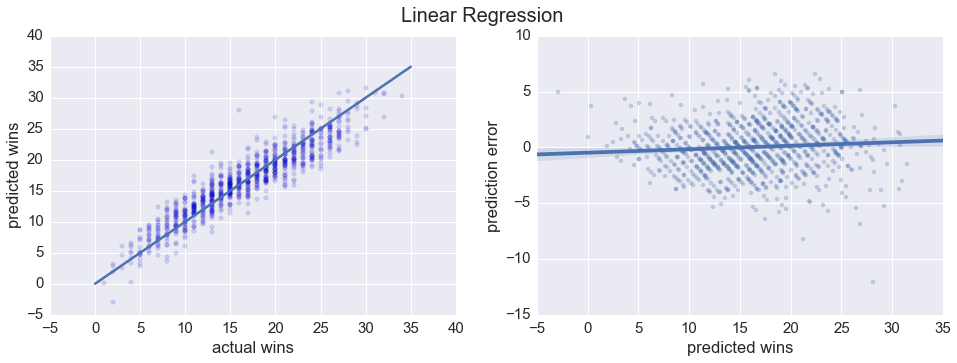

In [442]:
plot_regressor(linreg, y_test, X_test, 'Linear Regression')

Looks like a linear regression model does a pretty good job predicting total number of wins. Just for kicks, let's try a [Random Forest](https://en.wikipedia.org/wiki/Random_forest) regression as well.

Pearson R : 0.9152
R^2       : 0.8374
RMSE      : 2.5010


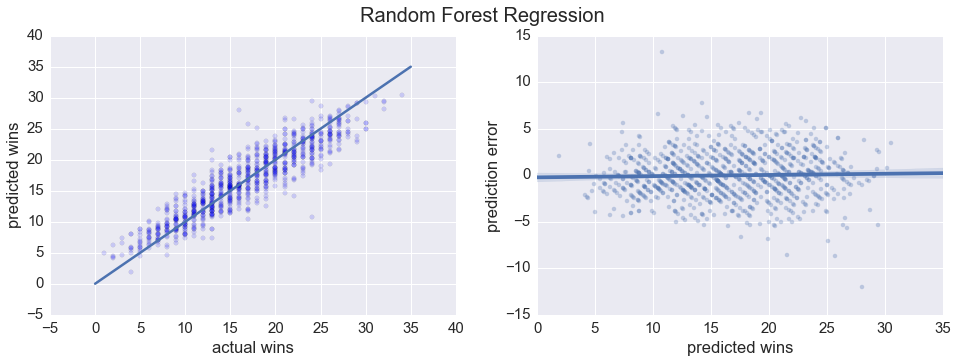

In [443]:
forest = ensemble.RandomForestRegressor(random_state=0)
forest.fit(X_train, y_train)

plot_regressor(forest, y_test, X_test, 'Random Forest Regression')

All in all, pretty similar. We can look at the distribution of the prediction errors for both regressions to get a more direct visual sense of how they compare.

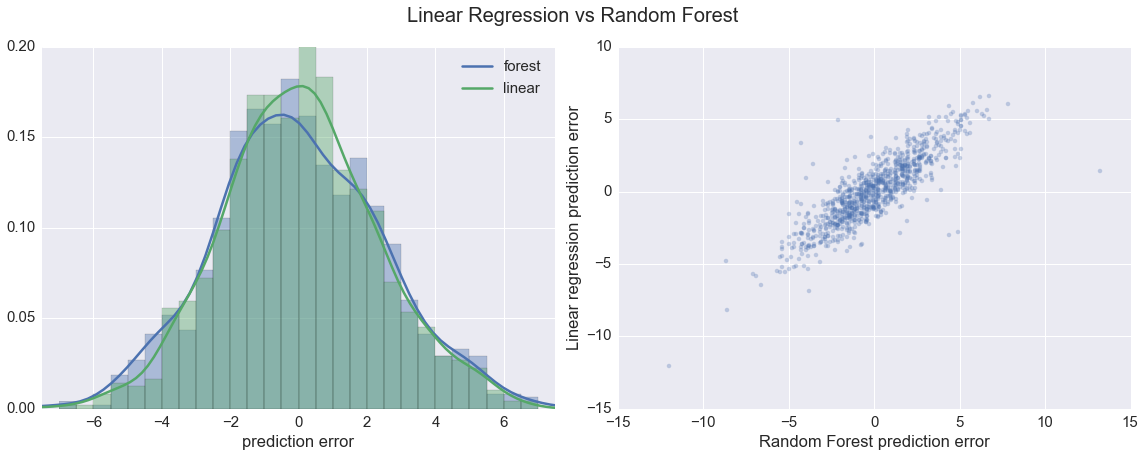

In [462]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

compare = pd.DataFrame(y_test)
compare['forest'] = forest.predict(X_test)
compare['linear'] = linreg.predict(X_test)
compare['avg'] = (compare['forest'] + compare['linear']) / 2
compare['pred_diff'] = compare['forest'] - compare['linear']

compare['forest_diff'] = compare['total_wins'] - compare['forest']
compare['linear_diff'] = compare['total_wins'] - compare['linear']

bins = np.arange(-7,7.25, 0.5)
sns.distplot(compare['forest_diff'], kde_kws={'label':'forest'}, bins=bins, ax=ax1)
sns.distplot(compare['linear_diff'], kde_kws={'label':'linear'}, bins=bins, ax=ax1)
ax1.set_xlim([-7.5,7.5]);
ax1.set_xlabel('prediction error')
plt.suptitle('Linear Regression vs Random Forest', fontsize=20, y=1.051);

sns.regplot(compare['forest_diff'], compare['linear_diff'], scatter_kws={'alpha':0.3}, fit_reg=False, ax=ax2)
ax2.set_xlabel('Random Forest prediction error')
ax2.set_ylabel('Linear regression prediction error')

plt.tight_layout()

In [456]:
print(compare.describe().ix[['mean','std']][['forest_diff','linear_diff']])

      forest_diff  linear_diff
mean    -0.015638     0.029887
std      2.502284     2.289120


The distributions of the prediction errors for the two models are very similar. More importantly, the errors of the two predictors are pretty strongly correlated. This latter point makes me somewhat confident that differences between predicted and actual wins are related to the performance of the team, and not just noisiness in the regression.

At this point we have a model that can predict a team's season wins based on that team's average statistics. Time for a change in perspective: instead of considering differences between predicted and actual wins to be prediction errors, let's consider them observations of over- or under-performance. If a team is predicted to win 20 games, but only wins 16, then instead of saying the model was wrong by 4 games we say that the team under-performed by 4 wins, and we attribute this under-performance (at least partially) to in-game coaching. This is definitely not rigorous, but hopefully the analysis will still be interesting.

We're ready for step two: compare Cornell's actual wins to predicted wins. The data we used to train the model only goes back to the 2008-2009 season, so I manually scraped Cornell's statistics through the 2001-2002 season. I'll omit that code as well and just show the results:

In [275]:
# next 3 cells: ugly manual scraping of Cornell data from 2002 season to present
cols = 'FGM	FGA	FTM	FTA	3PM	3PA	PTS	OREB	DEFR	REB	AST	TO	STL	BLK'.split()
'3PA', 'AST', 'BLK', 'FGA', 'FTA', 'OREB', 'PF', 'PTS',\
              'REB', 'STL', 'TO', 'PAPG', 'DEF_eff', 'OFF_eff'
index = list(range(2015,2001,-1))
cornell = [
    '549	1447	260	375	200	641	1558	257	627	884	339	395	188	64'.split(),
    '581	1357	307	488	172	505	1641	249	605	854	352	419	201	59'.split(),
    '659	1553	410	598	176	535	1904	348	669	1017	349	401	236	88'.split(),
    '614	1370	321	429	184	486	1733	254	555	809	353	388	179	82'.split(),
    '616	1446	334	468	196	538	1762	267	634	901	358	392	199	72'.split(),
    '641	1371	376	501	198	500	1856	244	637	881	367	413	161	89'.split(),
    '758	1562	392	515	228	558	2136	258	681	939	427	381	170	88'.split(),
    '821	1736	398	545	241	587	2281	321	784	1105	482	398	203	121'.split(),
    '913	1895	393	538	326	760	2545	349	796	1145	543	414	243	127'.split(),
    '658	1580	339	492	251	671	1906	301	605	906	406	338	186	72'.split(),
    '639	1568	338	494	217	637	1833	256	658	914	380	377	218	87'.split(),
    '732	1727	368	523	208	609	2040	308	697	1005	364	412	210	111'.split(),
    '652	1589	299	450	192	604	1795	292	588	880	300	337	117	78'.split(),
    '615	1558	457	610	181	579	1868	248	733	981	312	359	187	143'.split()
][::-1]

records = [
    [13,17],
    [2,26],
    [13,18],
    [12,16],
    [10,18],
    [29,5],
    [21,10],
    [22,6],
    [16,12],
    [13,15],
    [13,14],
    [11,16],
    [9,18],
    [5,22]
]

papg = [61.3, 78.4, 69.9, 67.8, 70.1, 64.5, 64.7, 68.5, 64.0, 63.4, 66.2, 69.8, 67.8, 66.6]

In [283]:
rec = pd.DataFrame(records, columns=['total_wins','total_loses'], index=index)
rec['games'] = rec['total_wins'] + rec['total_loses']

cu = pd.DataFrame(cornell, columns=cols, index=index).convert_objects(convert_numeric=True)
cu = cu.div(rec['games'],axis=0)
cu['PAPG'] = papg

df = pd.concat([cu, rec], axis=1).sort_index()
df.index.name = 'season'

In [437]:
X_cornell = df[fit_stats]
y_cornell = df['total_wins']
y_cornell_pred = linreg.predict(X_cornell)
y_diff = y_cornell - y_cornell_pred

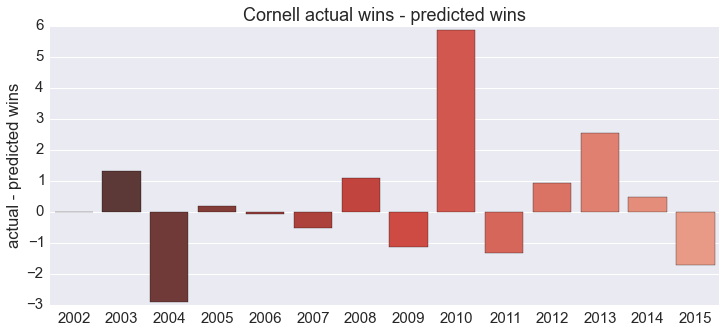

In [463]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.barplot(x=[int(yr) for yr in X_cornell.index.values], \
            y=y_diff, palette='Reds_d', ax=ax)

plt.ylabel('actual - predicted wins');
plt.title('Cornell actual wins - predicted wins');

A quick reminder: with this analysis we're only addressing in-game coaching. 2014 was a miserable season for Cornell (they went 2-26), and coaching was surely a factor. According to this, however, in-game coaching wasn't to blame: Cornell won about 1/2 game more than they were predicted to based on their season-average statistics, which is well within a standard deviation of the mean.

Cornell changed coaches between the 2010 and 2011 seasons; looking at the plot it's hard to say if the performance is markedly different before and after the change. This is where Bayesian tools come in, specifically a [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) (MCMC) method. The python package [PyMC](https://github.com/pymc-devs/pymc) implements the heavy machinery for us, and I'll defer to [Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/) for a detailed explanation of how it works; the model we're using here is lifted almost verbatim from the first chapter.

In [457]:
import pymc as pm

# our 'data' points are the difference between predicted
# and actual wins for each season
data = y_diff
n_data = len(data)
                  
# use the mean, stddev of the linear regression
# errors as our priors
mu_1 = pm.Normal('mu_1', 0.03, 2.3)
mu_2 = pm.Normal('mu_2', 0.03, 2.3)

tau = pm.DiscreteUniform("tau", lower=2002, upper=2015)

# model the over- or under-performance as being normally 
# distributed, both before and after the coaching change.
@pm.deterministic
def mu_(mu_1=mu_1, mu_2=mu_2, tau=tau):
    out = np.zeros(n_data)
    out[:tau] = mu_1
    out[tau:] = mu_2
    return out

observation = pm.Normal("obs", mu_, value=data, observed=True)

model = pm.Model([observation, mu_1, mu_2, tau])

mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

mu_1_samples = mcmc.trace('mu_1')[:]
mu_2_samples = mcmc.trace('mu_2')[:]
tau_samples = mcmc.trace('tau')[:]

 [-----------------100%-----------------] 40000 of 40000 complete in 7.9 sec

We're making two assumptions in the code above:
- For both coaches, the over- or under-performance of the team from season to season is normally distributed. The mean of this distrubtion is (at least partially) a function of the coach's in-game coaching skill. 
- At some point between the 2002 and 2015 seasons, there was a transition and the mean of the distribution changed.

These assumptions contain three parameters: the mean of the over/under performance distribution for each coach ($\mu_\texttt{ SD|BC}$), and the season during which the transition occurred ($\tau$). The PyMC code takes the assumptions above, and returns probability distributions for each of the three parameters based on the data we provide. If, as per our original hypothesis, the new coach (Bill Courtney)'s in-game coaching is significantly worse than the previous coach (Steve Donahue)'s, then the peaks of the two distriubtions returned by PyMC should be nicely separated, with Donahue's to the right of Courtney's. Additionally, the distribution for $\tau$, the season during which the transition occurred, should be sharply peaked around 2010.

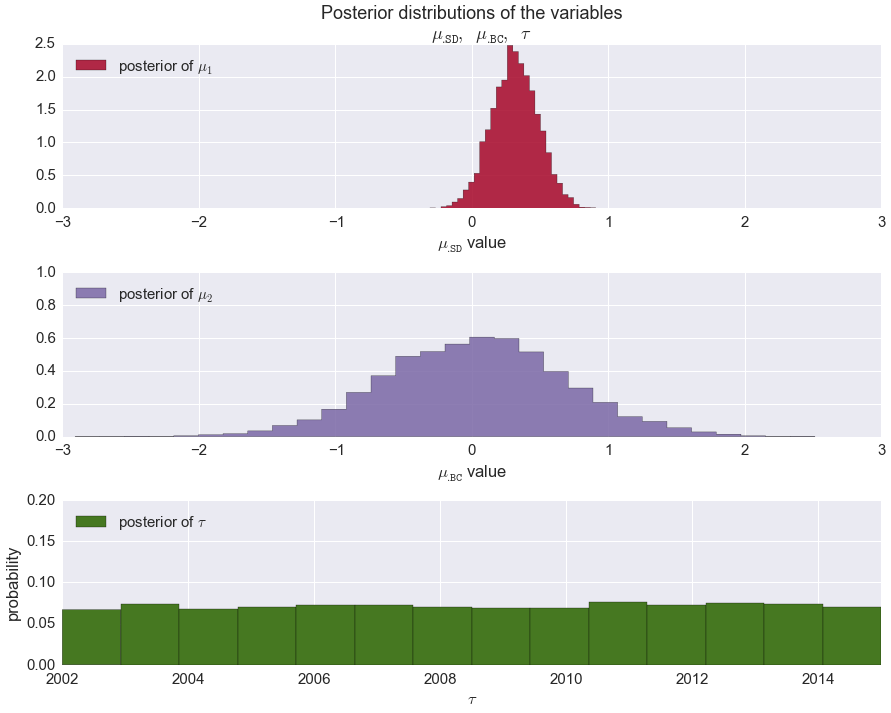

In [476]:
from IPython.core.pylabtools import figsize
figsize(12.5, 10)

ax = plt.subplot(311)
ax.set_autoscaley_on(True)

plt.hist(mu_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\mu_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\mu_\mathtt{. SD},\;\mu_\mathtt{. BC},\;\tau$""")
plt.xlim([-3, 3])
plt.xlabel("$\mu_\mathtt{. SD}$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(mu_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\mu_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([-3, 3])
plt.xlabel("$\mu_\mathtt{. BC}$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
#plt.xticks(np.arange(n_data))

plt.legend(loc="upper left")
plt.ylim([0, .2])
plt.xlim([2002, 2015])
plt.xlabel(r"$\tau$")
plt.ylabel("probability");

plt.tight_layout()

Well, looks like the data do not agree with our hypothesis. The most damning result is the flat distribution of $\tau$: according to our MCMC at no point in the past 13 years was there a drastic change in the quality of in-game coaching. Of course there are a number of other possible explanations, first among them that our mapping from prediction error to over/under performance was invalid. It could also be that we just don't have enough data yet. Good thing Cornell just gave Courtney a contract extension ...

Long story short, you can add this to the 
[list](http://thespread.us/causal-effects-of-coaching-changes.html) 
[of](http://fivethirtyeight.com/datalab/theres-not-much-evidence-a-new-coach-will-help-the-jets-49ers-or-falcons/)
[blog](http://freakonomics.com/2011/12/24/%E2%80%9Cfootball-freakonomics%E2%80%9D-does-firing-your-head-coach-fix-anything/)
[posts](http://archive.advancedfootballanalytics.com/2009/02/fighter-pilots-and-firing-coaches.html)
that conclude that it's hard to measure the effect of a coaching change. Sometimes the data just doesn't tell the story you want it to tell. 

The ipython notebook for this post is [here](/notebooks/2015-09-07-in-game-coaching.ipynb) and the data is [here](/data/box_scores.tar.gz) and [here](/data/game_scores.tar.gz).